In [41]:
import os
os.chdir('G:/My Drive/GitHub/VideoDiffusion/')
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print(torch.cuda.is_available())
torch.set_default_device('cuda')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

True


We choose to train only "cat" classes in CIFAR10

1.1 Dataset preview

Files already downloaded and verified


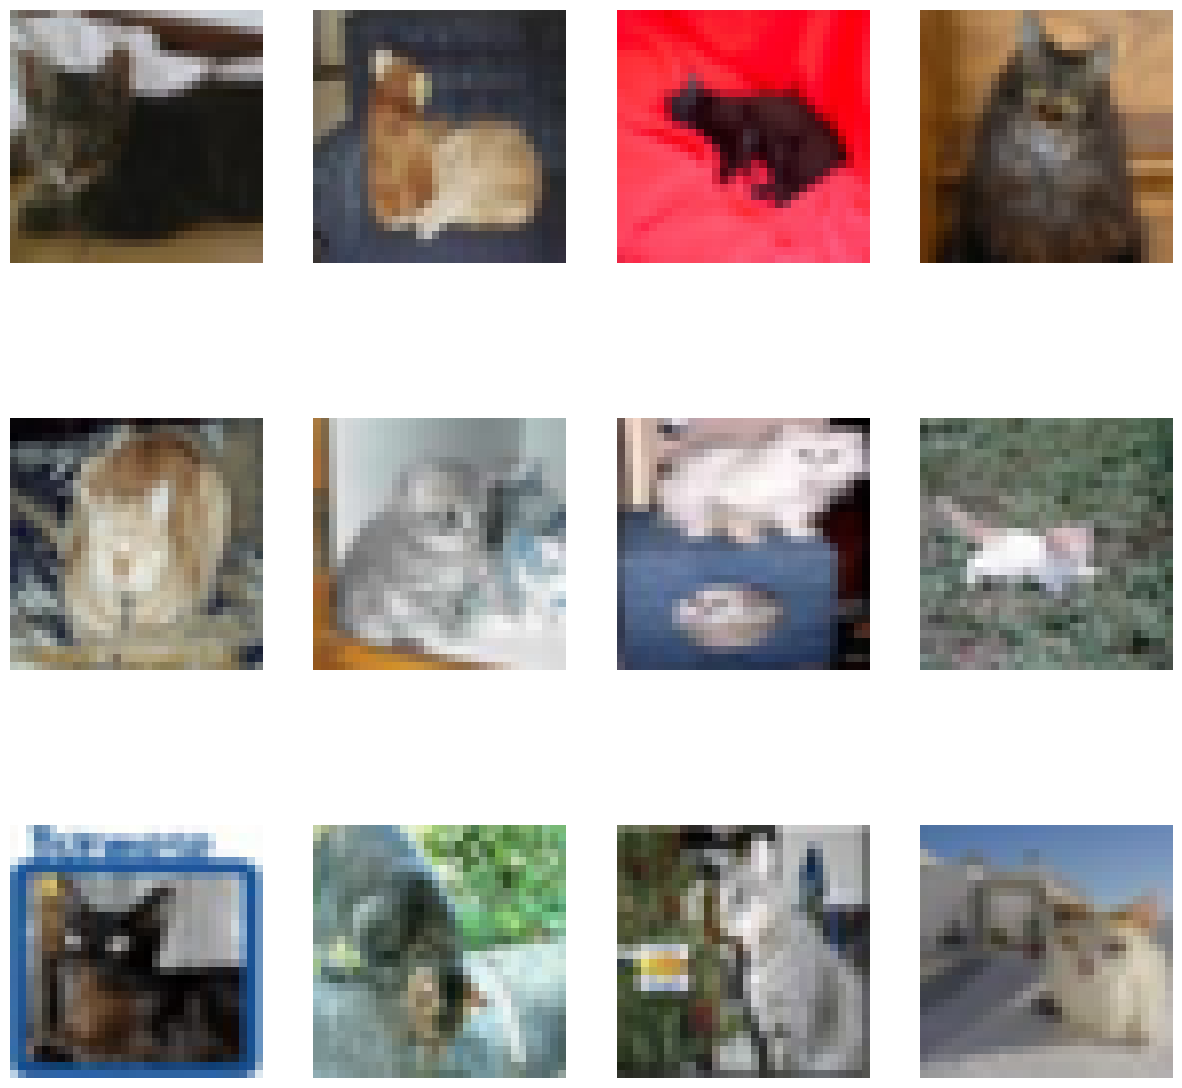

In [42]:
# Load CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(), 
])
all_dataset = torchvision.datasets.CIFAR10(root='./CIFAR', train=True, download=True, transform=transform)

# Get the cat class, and set the correct tensor format
classes = all_dataset.classes
cat_class_index = classes.index('cat')
cat_dataset_pre = [(img, label) for img, label in all_dataset if label == cat_class_index]
cat_dataset = [item[0].permute(1,2,0) for item in cat_dataset_pre]

# Example image plot
def img_plt(imgset, num_samples=12, cols=4):
    plt.figure(figsize=(15, 15))
    for i, img in enumerate(imgset):
        if i == num_samples:
            break
        plt.subplot(num_samples // cols, cols, i+1)
        plt.imshow(img)
        plt.axis('off')
img_plt(cat_dataset)

In [43]:
torch.min(cat_dataset[0])

tensor(0.0431, device='cpu')

1.2 Data loader

In [44]:
from torch.utils.data import DataLoader, RandomSampler
from torchvision import transforms

img_size1 = 32
batch_size1 = 100

def load_transform_data():
    data_transform = transforms.Compose([
        transforms.Resize((img_size1, img_size1)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), 
        transforms.Lambda(lambda x: x*2-1 )
    ])
    
    train_set = torchvision.datasets.CIFAR10(root='./CIFAR_train', train=True, download=True, transform=data_transform)
    test_set = torchvision.datasets.CIFAR10(root='./CIFAR_test', train=False, download=True, transform=data_transform)
    total_set = torch.utils.data.ConcatDataset([train_set, test_set])
    return total_set
# since this is a generative AI model, we don't need to split the dataset into train and test

def show_sample_image(image):
    image_transform = transforms.Compose([
        transforms.Lambda(lambda x: (x+1)/2 ),
        transforms.Lambda(lambda x: x.permute(1,2,0) ), # to H,W,C
        transforms.Lambda(lambda x: x*255 ),
        transforms.Lambda(lambda x: x.numpy().astype(np.uint8) ),
        transforms.ToPILImage()
    ])
    
    # For batched dataset
    image = image.to('cpu')
    if len(image.shape) == 4:
        image = image[0,:,:,:]
    plt.imshow(image_transform(image))

data_all = load_transform_data()  
data_cat = [item for item in data_all if item[1] == cat_class_index]


generator = torch.Generator(device=device)
generator.manual_seed(42)
sampler = RandomSampler(data_cat, generator=generator)
data_loader = DataLoader(data_cat, batch_size=batch_size1, sampler=sampler, drop_last=True)


Files already downloaded and verified
Files already downloaded and verified


2.1  Noise scheduler - Forward process

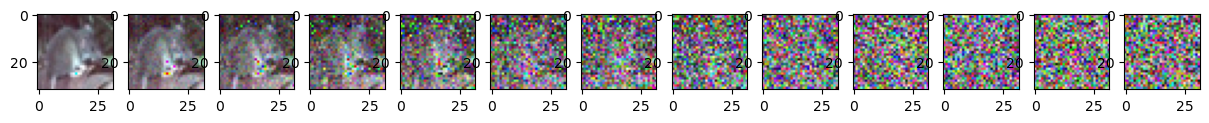

In [45]:
import torch.nn.functional as F


# Define beta, alpha
timesteps = 100
beta_start = 1e-4
beta_end = 2e-2
beta = torch.linspace(beta_start, beta_end, timesteps)

# Define the closed-form scheduler
alpha = 1. - beta
alpha_cumprod = torch.cumprod(alpha, dim=0)
alpha_cumprod_pad1 = F.pad(alpha_cumprod[:-1], (1, 0), value=1.) # let 'alpha list' start from 1, and drop the last element
sqrt_recip_alpha = torch.sqrt(1./alpha)
sqrt_alpha_cumprod = torch.sqrt(alpha_cumprod)
sqrt_oneminus_alpha_cumprod = torch.sqrt(1-alpha_cumprod)
posterior_variance = beta * (1. - alpha_cumprod_pad1) / (1. - alpha_cumprod)

def get_index(list1, t, x_shape):
    batch_size = t.shape[0]
    output = list1.gather(-1,t.to(device))
    return output.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion(x_0, t, device=device):
    noise = torch.randn_like(x_0)
    sqrt_alpha_cumprod_t = get_index(sqrt_alpha_cumprod, t, x_0.shape)
    sqrt_oneminus_alpha_cumprod_t = get_index(sqrt_oneminus_alpha_cumprod, t, x_0.shape)
    x_t = sqrt_alpha_cumprod_t.to(device) * x_0.to(device) + sqrt_oneminus_alpha_cumprod_t.to(device) * noise.to(device)
    return x_t, noise.to(device)



image = next(iter(data_loader))[0] # get the first batch
num_samples = 12
step_size = timesteps//num_samples #100//12=8

plt.figure(figsize=(15, 15))
for i in range(0, timesteps, step_size):
    t = torch.tensor([i]).type(torch.long)
    plt.subplot(1, num_samples+1, i//step_size+1) # start from x_0 (uncorrupted), so +1
    img, noise = forward_diffusion(image, t)
    show_sample_image(img)

2.2 U-Net: Backword process

In [46]:
from torch import nn
import math

######################################### Blocks #########################################
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, t_emb_dim, up=False): # up: upsample, the DEFAULT is downsampling
        super().__init__()
        self.t_mlp = nn.Linear(t_emb_dim, out_ch) # Linear layer: time_channel ->= feature_channel
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1) # interlayer transform, in upsampling it is expanding the space dimension
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1) # in downsampling it is shrinking the space dimension
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t): #CRB -> time embedding -> CRB -> transform
        h = self.bnorm1(self.relu(self.conv1(x))) # layer 1
        t_emb = self.relu(self.t_mlp(t)) # first linear map the t_dim then ReLU
        t_emb = t_emb[(...,) + (None,) * 2] # add dimension to match h
        h = h + t_emb

        h = self.bnorm2(self.relu(self.conv2(h))) # conv layer 2
        h = self.transform(h)  
        return h

class PositionalEncoding(nn.Module):
    def __init__(self, dim, n=10000): # 4?
        super().__init__()
        self.dim = dim
        self.n = n
        
    def forward(self, t):
        device = t.device
        dim_half = self.dim // 2
        emb = math.log(self.n) / (dim_half - 1) # check here this '-1'
        emb = torch.exp(torch.arange(dim_half, device=device) * -emb) 
        emb = t[:, None] * emb[None, :] # Cartesian product: t * Transpose(emb) (batch_size, dim_half)
        emb = torch.cat([emb.sin(), emb.cos()], dim=-1) # (batch_size, 2*dim_half)
        return emb

######################################### UNet Model #########################################
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_ch = 3
        down_ch = (64, 128, 256, 512, 1024)
        up_ch = (1024, 512, 256, 128, 64)
        out_dim = 3
        t_emb_dim = 32

        self.t_mlp = nn.Sequential(
            PositionalEncoding(t_emb_dim),
            nn.Linear(t_emb_dim, t_emb_dim),
            nn.ReLU()
        )
        self.conv0 = nn.Conv2d(img_ch, down_ch[0], 3, padding=1)
        self.down1 = nn.ModuleList(
            [Block(down_ch[i], down_ch[i+1], t_emb_dim, up=False) for i in range(len(down_ch)-1)]
        )
        self.up1 = nn.ModuleList(
            [Block(up_ch[i], up_ch[i+1], t_emb_dim, up=True) for i in range(len(up_ch)-1)]
        )
        self.output = nn.Conv2d(up_ch[-1], out_dim, 1)

    def forward(self, x, t_steps): # t_steps is a 1D list of time steps
        #get the embedded time tensor
        t = self.t_mlp(t_steps)
        x = self.conv0(x)
        Res = [] # cache the output of each down block for Residual connection
        for block in self.down1:
            x = block(x, t)
            Res.append(x)
        for block in self.up1:
            Res_current = Res.pop()
            x = torch.cat((x, Res_current), dim=1)
            x = block(x, t)
        x = self.output(x)
        return x

######################################### Test the Model #########################################

model = UNet().to(device)
print("The Structure of the Model: ", model)
print(f"Model is on CUDA: {next(model.parameters()).is_cuda}")


The Structure of the Model:  UNet(
  (t_mlp): Sequential(
    (0): PositionalEncoding()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down1): ModuleList(
    (0): Block(
      (t_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (t_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (tran

In [47]:
sqrt_oneminus_alpha_cumprod.is_cuda

True

1. The Positional Encoding needs to be revised